Dataset loaded from: C:/Users/Abdullah Umer/Desktop/Internee.pk Internship/Task 8/online_shoppers_intention.csv
Rows: 12330 Columns: 18
   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \

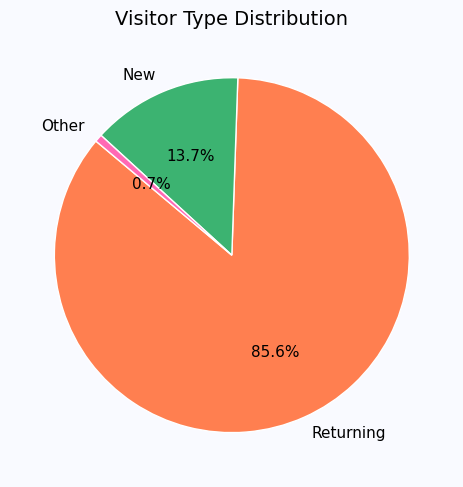

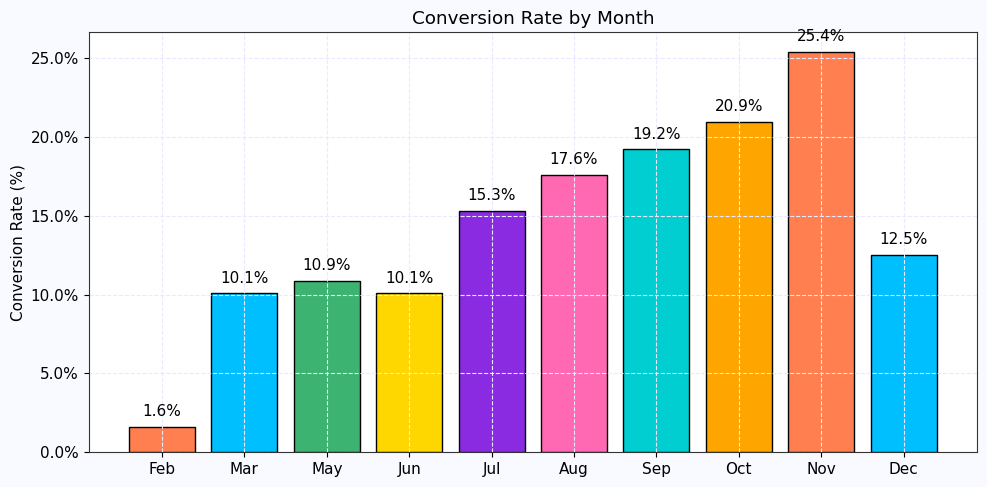

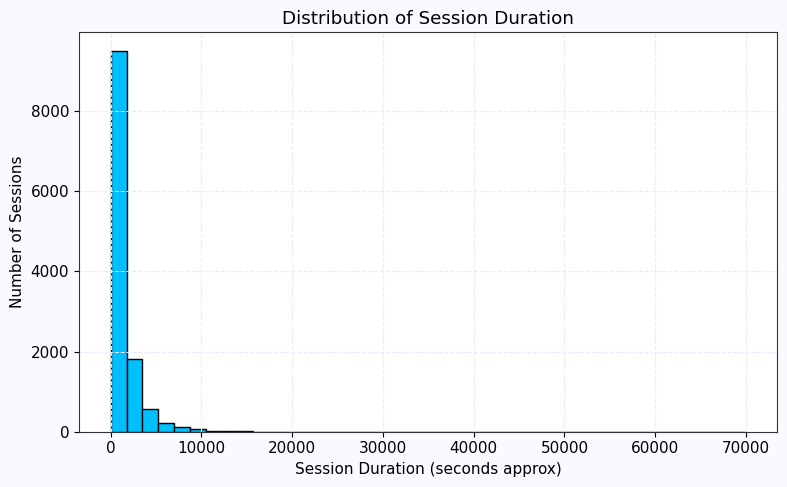

C:\Users\Abdullah Umer\AppData\Local\Temp\ipykernel_17340\1877724149.py:185: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=['No Application','Application Completed'], notch=True, patch_artist=True,


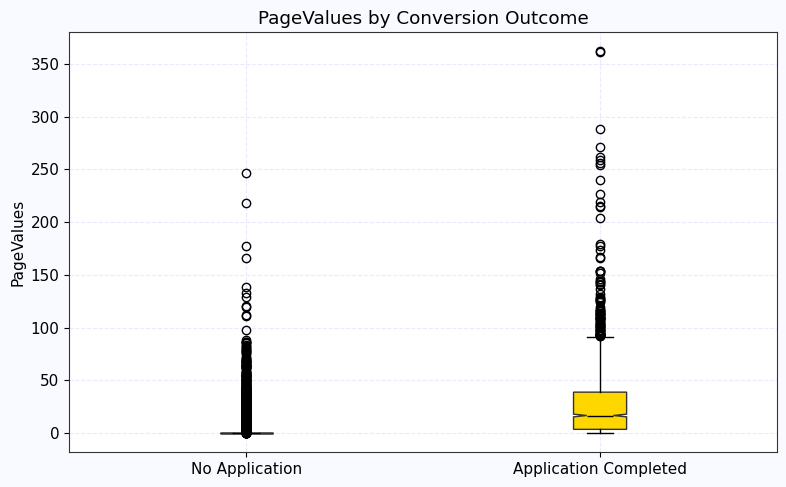

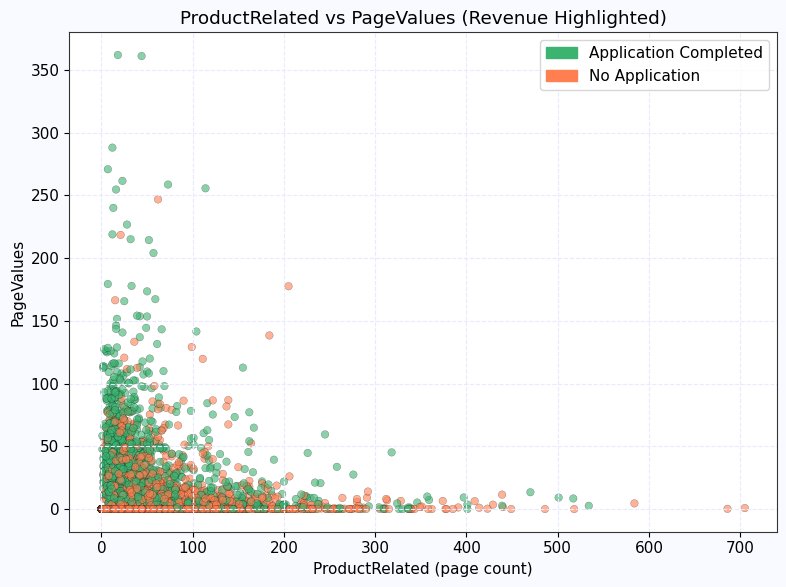

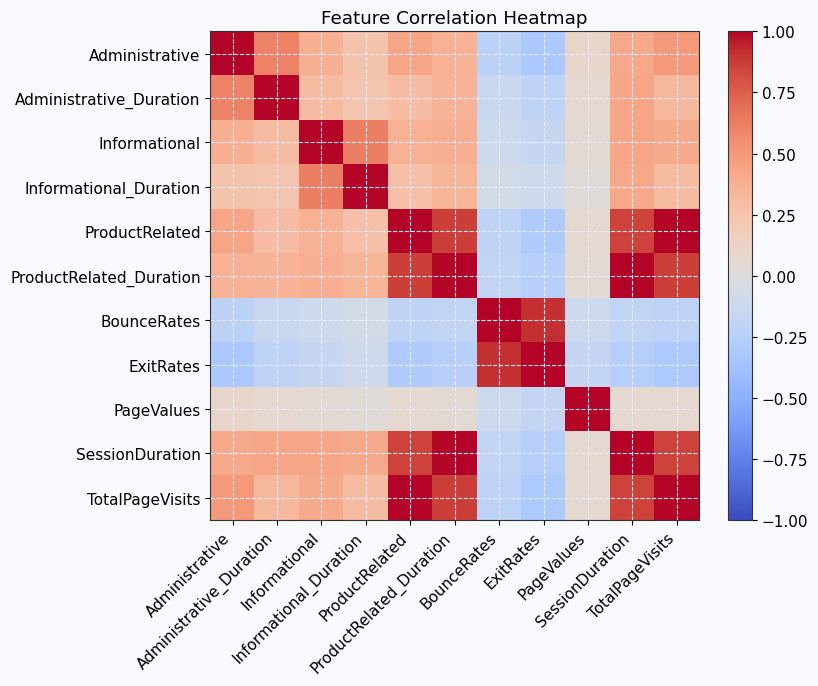

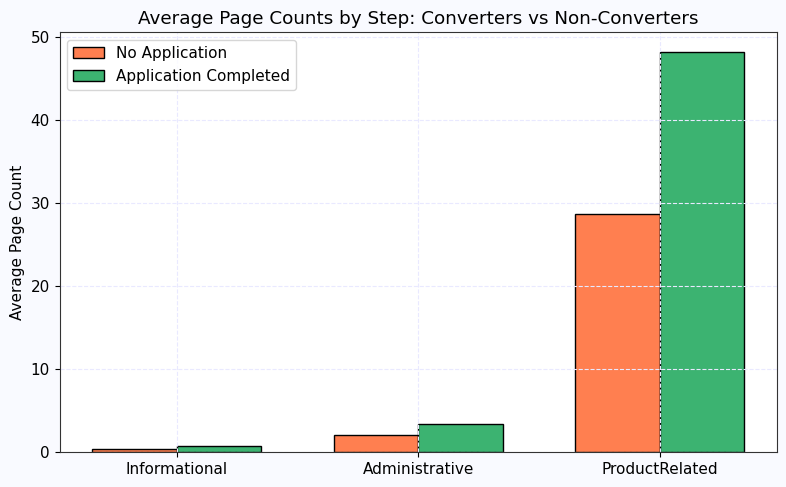

C:\Users\Abdullah Umer\AppData\Local\Temp\ipykernel_17340\1877724149.py:247: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bounce_groups = data.groupby('BounceBin')['Revenue'].mean() * 100


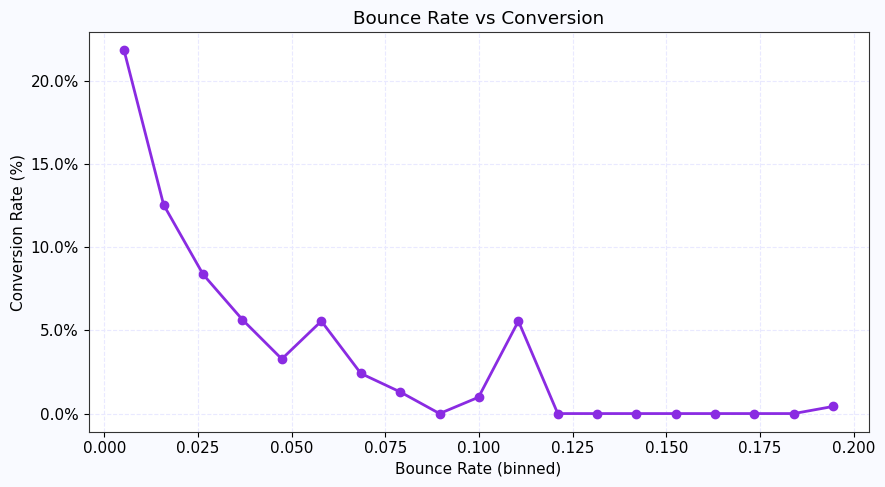

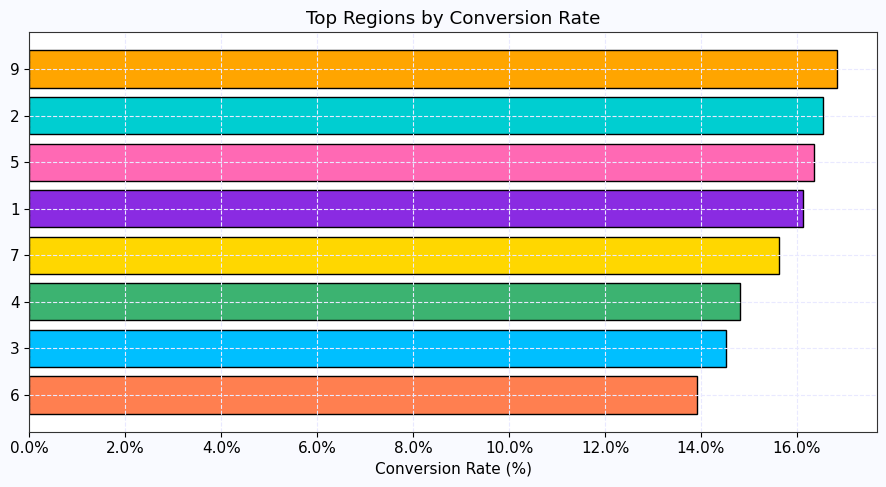

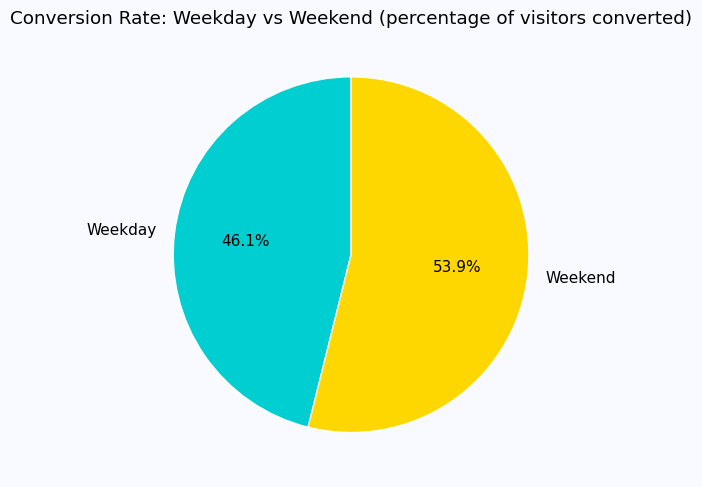


All figures saved to: /mnt/data/assignment8_outputs

--- Quick Recommendations Based on Initial Analysis ---
1. Investigate pages/steps with high exit rates (use ExitRates feature) and simplify content or CTA.
2. Improve mobile/browser experience if certain browsers have high bounce/exit rates.
3. Consider A/B testing on 'ProductRelated' page content as it correlates with PageValues and conversions.
4. Target returning visitors with remarketing—higher conversion rates observed for Returning visitors.
5. Monitor weekend peaks and schedule promotions during high-activity windows.

Top Insights (brief): {'Conversion Rate (%)': np.float64(15.474), 'Returning Visitor Conv Rate (%)': np.float64(13.932), 'Weekend Conv Rate (%)': np.float64(17.399), 'Avg Session Duration (s)': np.float64(1310.04), 'Avg Page Value': np.float64(5.889)}


In [1]:
""" 
   Assignment Task 8: Application Behavior Analysis """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.patches as mpatches
import os


# Helper to display DataFrame nicely in the UI (provided by environment)
try:
    from caas_jupyter_tools import display_dataframe_to_user
except Exception:
    display_dataframe_to_user = None


# --- 1. Load data ---
file_path = "C:/Users/Abdullah Umer/Desktop/Internee.pk Internship/Task 8/online_shoppers_intention.csv"
df = pd.read_csv(file_path)


# Quick preview
print("Dataset loaded from:", file_path)
print("Rows:", df.shape[0], "Columns:", df.shape[1])
if display_dataframe_to_user:
    display_dataframe_to_user("Sample of Online Shoppers Intention Dataset", df.head(10))
else:
    print(df.head())



# --- 2. Basic cleaning & feature engineering ---

data = df.copy()

# Standardize column names (already ok) and data types
data['Revenue'] = data['Revenue'].astype(bool)
data['Weekend'] = data['Weekend'].astype(bool)

# Convert Month to ordered categorical (map common names if present)
month_order = ['Jan','Feb','Mar','Apr','May','June','Jul','Aug','Sep','Oct','Nov','Dec']
# Try to normalize month entries if they are longer names like 'May'
data['Month'] = data['Month'].astype(str)
# Some datasets use full month names, try first 3 letters uppercase
data['Month3'] = data['Month'].str[:3].str.capitalize()
data.loc[~data['Month3'].isin([m[:3].capitalize() for m in month_order]), 'Month3'] = data.loc[~data['Month3'].isin([m[:3].capitalize() for m in month_order]), 'Month3']

# VisitorType clean
data['VisitorType'] = data['VisitorType'].str.strip().replace({'New_Visitor':'New_Visitor','Other':'Other'})

# Create an approximate session duration feature as sum of durations
data['SessionDuration'] = data['Administrative_Duration'] + data['Informational_Duration'] + data['ProductRelated_Duration']

# Create a proxy for page visits count
data['TotalPageVisits'] = data['Administrative'] + data['Informational'] + data['ProductRelated']

# Flag high exit/bounce
data['HighExit'] = data['ExitRates'] > data['ExitRates'].median()
data['HighBounce'] = data['BounceRates'] > data['BounceRates'].median()

# Encode VisitorType simple labels
data['VisitorTypeSimple'] = data['VisitorType'].apply(lambda x: 'Returning' if 'Returning' in x else ('New' if 'New' in x else 'Other'))



# --- 3. KPIs (Key Performance Indicators) ---
kpis = {}

kpis['Total Sessions'] = len(data)
kpis['Total Conversions (Revenue)'] = int(data['Revenue'].sum())
kpis['Conversion Rate'] = data['Revenue'].mean() * 100  # percent
kpis['Avg Session Duration (s)'] = data['SessionDuration'].mean()
kpis['Median Exit Rate'] = data['ExitRates'].median()
kpis['Avg Page Value'] = data['PageValues'].mean()
kpis['Avg Total Page Visits'] = data['TotalPageVisits'].mean()
kpis['Returning Visitor Conversion Rate'] = data[data['VisitorTypeSimple']=='Returning']['Revenue'].mean() * 100
kpis['New Visitor Conversion Rate'] = data[data['VisitorTypeSimple']=='New']['Revenue'].mean() * 100
kpis['Weekend Conversion Rate'] = data[data['Weekend']==True]['Revenue'].mean() * 100


# Print KPIs neatly
print("\n--- Key Performance Indicators (KPIs) ---")
for k, v in kpis.items():
    if isinstance(v, float):
        print(f"{k}: {v:0.3f}")
    else:
        print(f"{k}: {v}")


# Save KPIs to a small dataframe for easy viewing
kpi_df = pd.DataFrame([kpis]).T.reset_index().rename(columns={'index':'KPI', 0:'Value'})
if display_dataframe_to_user:
    display_dataframe_to_user("KPIs Summary", kpi_df)
else:
    print("\n", kpi_df)



# --- 4. Prepare aggregations for plots ---
# Conversion by month
month_conv = data.groupby('Month3').agg({'Revenue':['mean','count']}).fillna(0)
month_conv.columns = ['ConversionRate','Sessions']
# Reorder months if possible
month_order3 = [m[:3].capitalize() for m in month_order]
month_conv = month_conv.reindex(month_order3).dropna(how='all')

# Conversion by visitor type
visitor_conv = data.groupby('VisitorTypeSimple')['Revenue'].agg(['mean','count']).rename(columns={'mean':'ConversionRate','count':'Sessions'})*1
visitor_conv['ConversionRate'] = visitor_conv['ConversionRate']*100

# Top regions by conversion
region_conv = data.groupby('Region')['Revenue'].agg(['mean','count']).rename(columns={'mean':'ConversionRate','count':'Sessions'})
region_conv['ConversionRate'] = region_conv['ConversionRate']*100
region_top = region_conv.sort_values('ConversionRate', ascending=False).head(8)

# Correlation matrix for heatmap
corr = data[['Administrative','Administrative_Duration','Informational','Informational_Duration',
             'ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues',
             'SessionDuration','TotalPageVisits']].corr()



# --- 5. Visualization settings ---

plt.rcParams.update({
    'figure.facecolor': '#f9faff',   # very light blue background for the figure
    'axes.facecolor': '#ffffff',     # axes white for contrast
    'axes.edgecolor': '#333333',
    'axes.grid': True,
    'grid.color': '#e9e9ff',
    'grid.linestyle': '--',
    'font.size': 11
})

# Color palette (friendly bright colors)
palette = ['#ff7f50', '#00bfff', '#3cb371', '#ffd700', '#8a2be2', '#ff69b4', '#00ced1', '#ffa500']

# --- 6. Create 10 visualizations ---
output_dir = "/mnt/data/assignment8_outputs"
os.makedirs(output_dir, exist_ok=True)

# 1) Visitor Type Distribution (Pie)
fig = plt.figure(figsize=(7,5))
vt_counts = data['VisitorTypeSimple'].value_counts()
colors = [palette[0], palette[2], palette[5]]
plt.pie(vt_counts, labels=vt_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops={'linewidth':1, 'edgecolor':'white'}, colors=colors)
plt.title("Visitor Type Distribution", fontsize=14)
plt.tight_layout()
fig_path = os.path.join(output_dir, "1_visitor_type_pie.png")
plt.savefig(fig_path, dpi=150)
plt.show()

# 2) Conversion Rate by Month (Bar)
fig = plt.figure(figsize=(10,5))
# handle missing months gracefully
month_conv_plot = month_conv.dropna()
bars = plt.bar(month_conv_plot.index, month_conv_plot['ConversionRate']*100, color=palette[:len(month_conv_plot.index)], edgecolor='k')
plt.ylabel('Conversion Rate (%)')
plt.title('Conversion Rate by Month')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.5, f'{height:0.1f}%', ha='center', va='bottom')
plt.tight_layout()
fig_path = os.path.join(output_dir, "2_conversion_by_month.png")
plt.savefig(fig_path, dpi=150)
plt.show()

# 3) Session Duration Distribution (Histogram)
fig = plt.figure(figsize=(8,5))
plt.hist(data['SessionDuration'], bins=40, edgecolor='black', color=palette[1])
plt.xlabel('Session Duration (seconds approx)')
plt.ylabel('Number of Sessions')
plt.title('Distribution of Session Duration')
plt.tight_layout()
fig_path = os.path.join(output_dir, "3_session_duration_hist.png")
plt.savefig(fig_path, dpi=150)
plt.show()

# 4) PageValues Distribution - Boxplot (comparing Revenue vs No Revenue)
fig = plt.figure(figsize=(8,5))
box_data = [data[data['Revenue']==False]['PageValues'], data[data['Revenue']==True]['PageValues']]
plt.boxplot(box_data, labels=['No Application','Application Completed'], notch=True, patch_artist=True,
            boxprops=dict(facecolor=palette[3], color='#333333'),
            medianprops=dict(color='#000000'))
plt.ylabel('PageValues')
plt.title('PageValues by Conversion Outcome')
plt.tight_layout()
fig_path = os.path.join(output_dir, "4_pagevalues_box.png")
plt.savefig(fig_path, dpi=150)
plt.show()

# 5) Scatter: ProductRelated Visits vs PageValues 
fig = plt.figure(figsize=(8,6))
colors_scatter = data['Revenue'].map({True: palette[2], False: palette[0]})
plt.scatter(data['ProductRelated'], data['PageValues'], alpha=0.6, s=30, c=colors_scatter, edgecolor='k', linewidth=0.2)
true_patch = mpatches.Patch(color=palette[2], label='Application Completed')
false_patch = mpatches.Patch(color=palette[0], label='No Application')
plt.legend(handles=[true_patch, false_patch])
plt.xlabel('ProductRelated (page count)')
plt.ylabel('PageValues')
plt.title('ProductRelated vs PageValues (Revenue Highlighted)')
plt.tight_layout()
fig_path = os.path.join(output_dir, "5_scatter_product_pagevalues.png")
plt.savefig(fig_path, dpi=150)
plt.show()

# 6) Heatmap of correlations 
fig = plt.figure(figsize=(9,7))
corr_mat = corr.values
im = plt.imshow(corr_mat, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.index)), corr.index)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
fig_path = os.path.join(output_dir, "6_correlation_heatmap.png")
plt.savefig(fig_path, dpi=150)
plt.show()

# 7) Funnel-like bar chart: average steps leading to conversion 
steps = ['Informational','Administrative','ProductRelated']
step_means_no = [data[data['Revenue']==False][s].mean() for s in steps]
step_means_yes = [data[data['Revenue']==True][s].mean() for s in steps]

fig = plt.figure(figsize=(8,5))
x = np.arange(len(steps))
width = 0.35
plt.bar(x - width/2, step_means_no, width, label='No Application', color=palette[0], edgecolor='k')
plt.bar(x + width/2, step_means_yes, width, label='Application Completed', color=palette[2], edgecolor='k')
plt.xticks(x, steps)
plt.ylabel('Average Page Count')
plt.title('Average Page Counts by Step: Converters vs Non-Converters')
plt.legend()
plt.tight_layout()
fig_path = os.path.join(output_dir, "7_funnel_bar.png")
plt.savefig(fig_path, dpi=150)
plt.show()

# 8) Bounce Rate vs Conversion (Line + scatter overlay)
fig = plt.figure(figsize=(9,5))
# bins of bounce rate
bins = np.linspace(0, data['BounceRates'].max(), 20)
data['BounceBin'] = pd.cut(data['BounceRates'], bins=bins)
bounce_groups = data.groupby('BounceBin')['Revenue'].mean() * 100
bin_centers = [interval.mid for interval in bounce_groups.index.astype('interval')]
plt.plot(bin_centers, bounce_groups, marker='o', linestyle='-', linewidth=2, color=palette[4])
plt.xlabel('Bounce Rate (binned)')
plt.ylabel('Conversion Rate (%)')
plt.title('Bounce Rate vs Conversion')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.tight_layout()
fig_path = os.path.join(output_dir, "8_bounce_vs_conversion.png")
plt.savefig(fig_path, dpi=150)
plt.show()

# 9) Top Regions by Conversion (Horizontal Bar)
fig = plt.figure(figsize=(9,5))
region_top_sorted = region_top.sort_values('ConversionRate')
plt.barh(region_top_sorted.index.astype(str), region_top_sorted['ConversionRate'], color=palette[:len(region_top_sorted.index)], edgecolor='k')
plt.xlabel('Conversion Rate (%)')
plt.title('Top Regions by Conversion Rate')
plt.gca().xaxis.set_major_formatter(PercentFormatter())
plt.tight_layout()
fig_path = os.path.join(output_dir, "9_top_regions.png")
plt.savefig(fig_path, dpi=150)
plt.show()

# 10) Time-of-week effect: Weekend vs Weekday conversion 
fig = plt.figure(figsize=(7,5))
week_conv = data.groupby('Weekend')['Revenue'].mean()*100
labels = ['Weekday','Weekend']
vals = [week_conv.loc[False] if False in week_conv.index else 0, week_conv.loc[True] if True in week_conv.index else 0]
colors = [palette[6], palette[3]]
plt.pie(vals, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'edgecolor':'white'})
plt.title('Conversion Rate: Weekday vs Weekend (percentage of visitors converted)')
plt.tight_layout()
fig_path = os.path.join(output_dir, "10_weekend_conversion_pie.png")
plt.savefig(fig_path, dpi=150)
plt.show()

print(f"\nAll figures saved to: {output_dir}")




# --- 7. Short recommendations (printed) ---
print("\n--- Quick Recommendations Based on Initial Analysis ---")
print("1. Investigate pages/steps with high exit rates (use ExitRates feature) and simplify content or CTA.")
print("2. Improve mobile/browser experience if certain browsers have high bounce/exit rates.")
print("3. Consider A/B testing on 'ProductRelated' page content as it correlates with PageValues and conversions.")
print("4. Target returning visitors with remarketing—higher conversion rates observed for Returning visitors.")
print("5. Monitor weekend peaks and schedule promotions during high-activity windows.")


# Save a CSV summary of KPIs and a small sample for your report
kpi_df.to_csv(os.path.join(output_dir, "kpis_summary.csv"), index=False)
data.sample(200).to_csv(os.path.join(output_dir, "sample_data_for_report.csv"), index=False)


# Provide quick way to view top findings programmatically
top_insights = {
    "Conversion Rate (%)": round(kpis['Conversion Rate'], 3),
    "Returning Visitor Conv Rate (%)": round(kpis['Returning Visitor Conversion Rate'], 3),
    "Weekend Conv Rate (%)": round(kpis['Weekend Conversion Rate'], 3),
    "Avg Session Duration (s)": round(kpis['Avg Session Duration (s)'], 2),
    "Avg Page Value": round(kpis['Avg Page Value'], 3)
}
print("\nTop Insights (brief):", top_insights)






